In [1]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely.validation import make_valid

Data Sources:
* RFF (bottom of [this page](https://www.resources.org/common-resources/what-is-an-energy-community/))
* VCE [here](https://www.vibrantcleanenergy.com/media/reports/)
* [census](https://www2.census.gov/geo/tiger/TIGER2022/COUNTY/)

In [2]:
shape_path_county = Path("./county_shapefile_2022/tl_2022_us_county.shp")
assert shape_path_county.exists()

In [3]:
counties = gpd.read_file(shape_path_county)

In [4]:
counties.head(2)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477644346,10691216,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980770,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."


In [5]:
shape_vce_ec = Path("./ira_energy_communities_data/vce/EC_Shapefiles/EnergyCommunities_release.shp")
assert shape_vce_ec.exists()

In [6]:
vce_ec = gpd.read_file(shape_vce_ec)

In [7]:
vce_ec.shape

(27816, 2)

In [8]:
vce_ec.head(2)

,Site,geometry
0,0,"POLYGON Z ((-86.62621 32.70622 0.00000, -86.62..."
1,1,"MULTIPOLYGON Z (((-87.81620 30.94044 0.00000, ..."


In [9]:
type(vce_ec.iat[0,1])

shapely.geometry.polygon.Polygon

In [10]:
vce_ec.iat[0,1].bounds

(-86.92123700099995, 32.52383000100008, -86.60437999799996, 32.70621562000008)

In [11]:
vce_ec.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
counties.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [13]:
brownfield_rff = gpd.read_file(Path("./ira_energy_communities_data/rff/brownfields/brownfields.shp"))

In [14]:
brownfield_rff.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

2/3 use NAD83 so I'll convert vce to use it as well

# Fix VCE Shapefile
* convert Coordinate Reference System to NAD83 to match the other two sources
* fix broken polygons that break spatial joins based on 'touches'

In [15]:
bad = [row[0] for row in vce_ec['geometry'].items() if not row[1].is_valid]
len(bad)

9

In [16]:
bad

[2602, 9478, 9996, 12542, 12813, 14417, 15489, 17135, 27698]

In [17]:
fixes = vce_ec.loc[bad,'geometry'].apply(lambda x: make_valid(x))

In [18]:
fixes

2602     MULTIPOLYGON Z (((-113.17884 42.71619 0.00000,...
9478     MULTIPOLYGON Z (((-82.51307 35.97529 0.00000, ...
9996     MULTIPOLYGON Z (((-80.51851 37.40999 0.00000, ...
12542    MULTIPOLYGON Z (((-80.51851 37.40999 0.00000, ...
12813    MULTIPOLYGON Z (((-80.62693 37.43301 0.00000, ...
14417    MULTIPOLYGON Z (((-82.78417 35.98186 0.00000, ...
15489    MULTIPOLYGON Z (((-82.51307 35.97529 0.00000, ...
17135    MULTIPOLYGON Z (((-80.51851 37.40999 0.00000, ...
27698    MULTIPOLYGON Z (((-80.62693 37.43301 0.00000, ...
Name: geometry, dtype: geometry

In [19]:
vce_ec.loc[fixes.index, 'geometry'] = fixes

In [20]:
vce_ec = vce_ec.to_crs(epsg=4269)

# Compare spatial joins

In [21]:
# "intersect" includes boundary points, so I need a second operation to
#vremove intersections that don't share any interior space.
counties.sjoin(vce_ec, how='left', predicate='intersects').shape

(56083, 20)

In [22]:
counties.shape

(3235, 18)

In [28]:
counties.sjoin(vce_ec, how='left', predicate='covered_by').drop_duplicates(subset='GEOID').dropna(subset='Site').shape

(0, 20)

In [29]:
counties.sjoin(vce_ec, how='left', predicate='intersects').drop_duplicates(subset='GEOID').dropna(subset='Site').shape

(3013, 20)

In [30]:
counties.sjoin(vce_ec, how='left', predicate='touches').drop_duplicates(subset='GEOID').dropna(subset='Site').shape

(0, 20)

In [26]:
#Look at nebraska only because VCE shapefile does not cover much of the state so it should not return many counties
nebraska = counties[counties['STATEFP'].eq('31')]
nebraska.shape

(93, 18)

In [31]:
neb_vce_intersect = nebraska.sjoin(vce_ec, how='left', predicate='intersects').drop_duplicates(subset='GEOID').dropna(subset='Site')

In [32]:
neb_vce_intersect.shape

(81, 20)

In [33]:
{'Cherry', 'Grant', 'Hooker', 'Thomas'}.difference(set(neb_vce_intersect['NAME'].to_list()))

{'Hooker', 'Thomas'}

<AxesSubplot: >

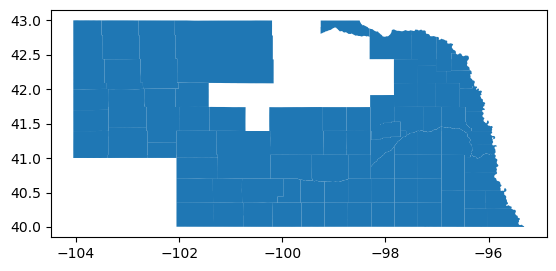

In [36]:
neb_vce_intersect['geometry'].plot()

In [45]:
counties.loc[:1, 'geometry']#.buffer(0.1)

0    POLYGON ((-96.55515 41.91587, -96.55515 41.914...
1    POLYGON ((-123.72755 46.26449, -123.72755 46.2...
Name: geometry, dtype: geometry

In [47]:
counties.loc[:1, 'geometry'].buffer(0.2)

/tmp/ipykernel_29774/329989330.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties.loc[:1, 'geometry'].buffer(0.2)


0    POLYGON ((-97.21981 41.75380, -97.21980 41.757...
1    POLYGON ((-123.92775 46.27778, -123.92781 46.2...
dtype: geometry

In [48]:
counties.loc[:1, 'geometry'].buffer(-0.2)

/tmp/ipykernel_29774/82828183.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties.loc[:1, 'geometry'].buffer(-0.2)


0    POLYGON EMPTY
1    POLYGON EMPTY
dtype: geometry

In [49]:
counties.loc[:1, 'geometry'].scale(0.999)

0    POLYGON ((-96.55539 41.91587, -96.55539 41.914...
1    POLYGON ((-123.72730 46.26449, -123.72730 46.2...
dtype: geometry

In [44]:
counties.buffer(0.1)

/tmp/ipykernel_29774/3849374542.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties.buffer(0.1)


0       POLYGON ((-97.11984 41.74417, -97.11980 41.745...
1       POLYGON ((-123.82789 46.28828, -123.82789 46.2...
2       POLYGON ((-104.99337 34.08950, -104.99337 34.0...
3       POLYGON ((-97.01372 40.65820, -97.01372 40.658...
4       POLYGON ((-98.37389 40.05798, -98.37402 40.064...
                              ...                        
3230    POLYGON ((-84.75524 34.68111, -84.75524 34.681...
3231    POLYGON ((-96.50552 48.99204, -96.50556 48.993...
3232    POLYGON ((-90.54985 32.55987, -90.54994 32.560...
3233    POLYGON ((-101.79403 32.15711, -101.79406 32.1...
3234    POLYGON ((-82.29349 37.82453, -82.29381 37.822...
Length: 3235, dtype: geometry

### Try scaling to remove intersections based only on boundary points

In [100]:
#Look at SCALED nebraska
scale_factor = 0.98
scaled_nebraska = counties[counties['STATEFP'].eq('31')].copy()
scaled_nebraska['geometry'] = scaled_nebraska['geometry'].scale(xfact=scale_factor, yfact=scale_factor)
nebraska.shape

(93, 18)

In [101]:
scaled_neb_vce_intersect = scaled_nebraska.sjoin(vce_ec, how='left', predicate='intersects').drop_duplicates(subset='GEOID').dropna(subset='Site')

In [102]:
scaled_neb_vce_intersect.shape

(68, 20)

In [103]:
{'Cherry', 'Grant', 'Hooker', 'Thomas'}.difference(set(scaled_neb_vce_intersect['NAME'].to_list()))

{'Cherry', 'Grant', 'Hooker', 'Thomas'}

<AxesSubplot: >

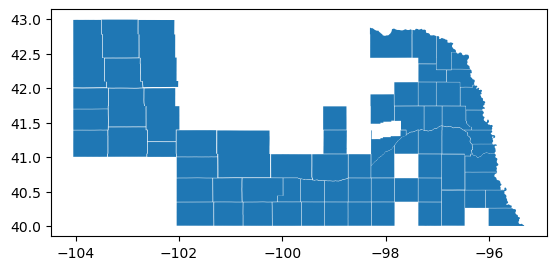

In [104]:
scaled_neb_vce_intersect['geometry'].plot()

# Repeat Intersection calc with down-scaled counties

In [119]:
scale_factor = 0.98
scaled_counties = counties.copy()
scaled_counties['geometry'] = scaled_counties['geometry'].scale(xfact=scale_factor, yfact=scale_factor)
scaled_counties.shape

(3235, 18)

In [120]:
scaled_vce_intersect = scaled_counties.sjoin(vce_ec, how='left', predicate='intersects').drop_duplicates(subset='GEOID').dropna(subset='Site')

In [121]:
scaled_vce_intersect.shape

(2892, 20)

In [122]:
# check some nebraska counties are correctly excluded
{'Cherry', 'Grant', 'Hooker', 'Thomas'}.difference(set(scaled_vce_intersect.loc[scaled_vce_intersect['STATEFP'].eq('31'),'NAME'].to_list()))

{'Cherry', 'Grant', 'Hooker', 'Thomas'}

<AxesSubplot: >

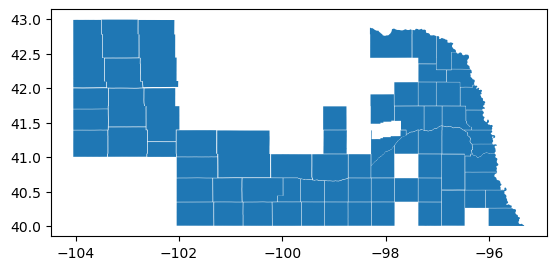

In [123]:
scaled_vce_intersect.loc[scaled_vce_intersect['STATEFP'].eq('31'), 'geometry'].plot()

In [162]:
scaled_vce_intersect.shape

(2892, 20)

In [124]:
scaled_vce_intersect.shape[0] / counties.shape[0]

0.8939721792890263

Only 10.6% of counties DONT qualify!

# RFF version

In [125]:
brownfield_rff = gpd.read_file(Path("./ira_energy_communities_data/rff/brownfields/brownfields.shp"))
coal_mines_rff = gpd.read_file(Path("./ira_energy_communities_data/rff/closed_coal_mines/closed_coal_mines.shp"))
coal_plants_rff = gpd.read_file(Path("./ira_energy_communities_data/rff/retired_coal_plants/retired_coal_plants.shp"))
# energy_employment_rff = gpd.read_file(Path("./ira_energy_communities_data/rff/energy_employment/energy_employment.shp"))
energy_and_total_employment_rff = gpd.read_file(Path("./ira_energy_communities_data/rff/energy_employment_total_unemployment/energy_employment_total_unemployment.shp"))

In [128]:
brownfield_rff.head(2)

,Name,geometry
0,BUCK CREEK MILL,POINT (-86.82603 33.23197)
1,ALATEX MILL (NEW MILL SECTION FORMERLY),POINT (-86.49298 31.31609)


In [129]:
counties.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

In [130]:
brownfield_rff.isna().sum()

Name        0
geometry    0
dtype: int64

In [131]:
counties.sjoin(brownfield_rff, how='left', predicate='intersects').drop_duplicates(subset='GEOID').dropna(subset='Name').shape

(2003, 20)

In [148]:
# I don't think I should use scaled counties on brownfields because they are points, not areas, so shouldn't have the boundary point problems that areas have.
scaled_counties.sjoin(brownfield_rff, how='left', predicate='intersects').drop_duplicates(subset='GEOID').dropna(subset='Name').shape

(1988, 20)

In [132]:
# can use contains because brownfields are represented with points, not areas
counties.sjoin(brownfield_rff, how='left', predicate='contains').drop_duplicates(subset='GEOID').dropna(subset='Name').shape

(2003, 20)

In [133]:
coal_mines_rff.head(2)

,GEOID,geometry
0,01009050500,"POLYGON ((846408.194 1253602.844, 846518.301 1..."
1,01071950400,"POLYGON ((873401.487 1357222.873, 873691.320 1..."


In [134]:
coal_mines_rff.isna().sum()

GEOID       0
geometry    0
dtype: int64

In [135]:
counties.sjoin(coal_mines_rff.rename(columns={'GEOID': 'tract_FIPS'}), how='left', predicate='intersects').drop_duplicates(subset='GEOID').dropna(subset='tract_FIPS').shape

/home/tpb/mambaforge/envs/pudl-impute/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: EPSG:5070

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


(0, 20)

In [136]:
coal_mines_rff.crs

<Derived Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [137]:
coal_mines_rff = coal_mines_rff.to_crs(epsg=4269)

In [138]:
counties.sjoin(coal_mines_rff.rename(columns={'GEOID': 'tract_FIPS'}), how='left', predicate='intersects').drop_duplicates(subset='GEOID').dropna(subset='tract_FIPS').shape

(859, 20)

In [149]:
scaled_counties.sjoin(coal_mines_rff.rename(columns={'GEOID': 'tract_FIPS'}), how='left', predicate='intersects').drop_duplicates(subset='GEOID').dropna(subset='tract_FIPS').shape

(711, 20)

In [140]:
coal_plants_rff = coal_plants_rff.to_crs(epsg=4269)

In [142]:
counties.sjoin(coal_plants_rff.rename(columns={'GEOID': 'tract_FIPS'}), how='left', predicate='intersects').drop_duplicates(subset='GEOID').dropna(subset='tract_FIPS').shape

(1021, 20)

In [152]:
scaled_counties.sjoin(coal_plants_rff.rename(columns={'GEOID': 'tract_FIPS'}), how='left', predicate='intersects').drop_duplicates(subset='GEOID').dropna(subset='tract_FIPS').shape

(726, 20)

In [144]:
energy_and_total_employment_rff = energy_and_total_employment_rff.to_crs(epsg=4269)

In [146]:
energy_and_total_employment_rff.isna().sum()

msa_code    0
geometry    0
dtype: int64

In [147]:
counties.sjoin(energy_and_total_employment_rff, how='left', predicate='intersects').drop_duplicates(subset='GEOID').dropna(subset='msa_code').shape

(1200, 20)

In [153]:
scaled_counties.sjoin(energy_and_total_employment_rff, how='left', predicate='intersects').drop_duplicates(subset='GEOID').dropna(subset='msa_code').shape

(960, 20)

## Calculate and combine
Will used scaled counties for all pieces EXCEPT brownfields. This is because brownfields are represetned with points, not areas, so should not produce erroneous joins due to shared boundary points.

In [150]:
rff_counties = []

In [151]:
rff_counties.append(counties.sjoin(brownfield_rff, how='left', predicate='contains').drop_duplicates(subset='GEOID').dropna(subset='Name'))

In [157]:
rff_counties.append(scaled_counties.sjoin(coal_mines_rff.rename(columns={'GEOID': 'tract_FIPS'}), how='left', predicate='intersects').drop_duplicates(subset='GEOID').dropna(subset='tract_FIPS'))

In [158]:
rff_counties.append(scaled_counties.sjoin(coal_plants_rff.rename(columns={'GEOID': 'tract_FIPS'}), how='left', predicate='intersects').drop_duplicates(subset='GEOID').dropna(subset='tract_FIPS'))

In [159]:
rff_counties.append(scaled_counties.sjoin(energy_and_total_employment_rff, how='left', predicate='intersects').drop_duplicates(subset='GEOID').dropna(subset='msa_code'))

In [160]:
rff_final = pd.concat([df[['GEOID', 'NAME']] for df in rff_counties], ignore_index=True, axis=0).drop_duplicates(subset='GEOID')
rff_final.shape

(2603, 2)

In [161]:
rff_final.head(2)

,GEOID,NAME
0,31039,Cuming
1,31109,Lancaster


In [163]:
rff_final.shape[0] / counties.shape[0]

0.8046367851622874